<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [27]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import re
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

In [28]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
sw = stopwords.words('english')

In [30]:
df = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])

In [31]:
df.sample(5)

,text,toxic
46337,", but I think we both know your real reason fo...",0
12813,You made a factual error of tyrannosaurs \n\nY...,0
32425,Repeated vandalism by anon users \n\nJust thou...,0
49716,Public computer \n\nThis ip address is located...,0
112443,"""\n I am not forgetting to update them, its ju...",0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [33]:
df.text.isna().sum()

0

In [34]:
df.toxic.isna().sum()

0

**=> пропусков нет**

In [35]:
plt.rcParams["figure.figsize"] = (12,8)

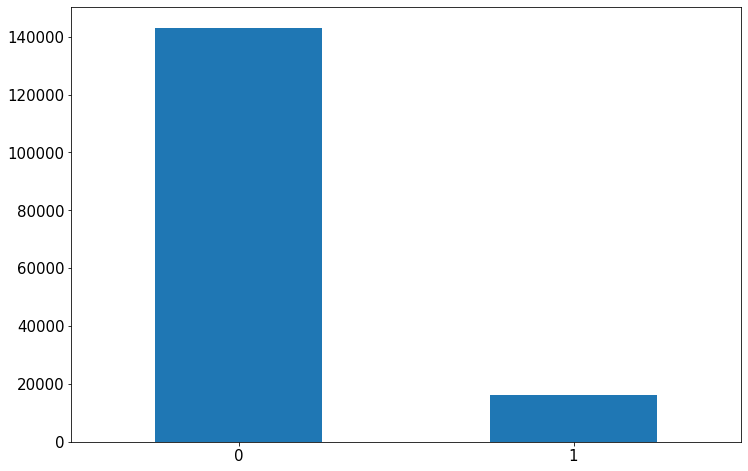

In [36]:
df['toxic'].value_counts().plot(kind='bar', fontsize=15)
_ = plt.xticks(rotation = 0)

**=> Виден сильный дисбаланс классов**

In [37]:
df['text'] = df['text'].str.lower()

In [38]:
def clear_text(text):
    clear_list = re.sub(r'[^a-zA-Z ]', ' ', text)
    clear_text = " ".join(clear_list.split())
    return clear_text

In [39]:
df['text'] = df['text'].apply(clear_text)

In [41]:
m = WordNetLemmatizer()

In [42]:
def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    lemm_list = [m.lemmatize(w) for w in word_list]
    lemm_text = " ".join(lemm_list)
    return lemm_text

In [44]:
%%time

df['text'] = df['text'].apply(lemmatize)

CPU times: user 1min 17s, sys: 131 ms, total: 1min 17s
Wall time: 1min 17s


In [17]:
df.duplicated().sum()

1307

In [18]:
df = df.drop_duplicates()

In [19]:
df.duplicated().sum()

0

**=> дубликатов больше нет**

In [20]:
train, test = train_test_split(df, test_size=0.2, random_state=12345)
print(train.shape, test.shape)

(126388, 2) (31597, 2)


In [21]:
print("Соотношение классов в обучающей выборке:")
print(train['toxic'].value_counts())
print()
print("Соотношение классов в тестовой выборке:")
print(test['toxic'].value_counts())

Соотношение классов в обучающей выборке:
0    113552
1     12836
Name: toxic, dtype: int64

Соотношение классов в тестовой выборке:
0    28372
1     3225
Name: toxic, dtype: int64


In [22]:
corpus_train = train['text'].values
corpus_test = test['text'].values

target_train = train['toxic']
target_test = test['toxic']

print(corpus_train.shape, corpus_test.shape)
print(target_train.shape, target_test.shape)

(126388,) (31597,)
(126388,) (31597,)


In [23]:
%%time

count_tf_idf = TfidfVectorizer(min_df=2, stop_words=sw) 
tf_idf_train = count_tf_idf.fit_transform(corpus_train) 
tf_idf_test = count_tf_idf.transform(corpus_test) 

print("Размер матрицы:", tf_idf_train.shape)
print("Размер матрицы:", tf_idf_test.shape)

Размер матрицы: (126388, 56484)
Размер матрицы: (31597, 56484)
CPU times: user 6.41 s, sys: 88 ms, total: 6.5 s
Wall time: 6.54 s


В результате работы данного блока мы получили:
* Данные загружены
* Пропусков в данных не наблюдалось
* Повторные комментарии были удалени (их было < 1%)
* Был виден сильный дисбаланс классов
* созданы и подготовлены тестовые и тренировочные выборки данных для дальнейшего обучения моделей

## Обучение

Создадим словарь, в который будем записывать результаты F1-метрики моделей на тренировочных данных:

In [24]:
results = {}

<font size=5>**LogisticRegression**</font>

In [37]:
%%time

pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=sw)), ('lrc', LogisticRegression())])
parameters = {
    'tfidf__min_df': range(1, 3, 1),
    'lrc__C': [1, 10],
    'lrc__solver': ['newton-cg', 'liblinear']
}

lr_grid = RandomizedSearchCV(pipe, param_distributions=parameters, verbose=5, scoring='f1') 
lr_grid.fit(corpus_train, target_train) 

f1_train = round(abs(lr_grid.best_score_), 3)
print()
print(f"Значение F1 модели на трейне: {f1_train}")
print(f"Оптимальные гиперпараметры для модели: {lr_grid.best_params_}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=1; total time=  24.5s
[CV 2/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=1; total time=  25.9s
[CV 3/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=1; total time=  24.8s
[CV 4/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=1; total time=  25.7s
[CV 5/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=1; total time=  25.5s
[CV 1/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=2; total time=  23.5s
[CV 2/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=2; total time=  22.8s
[CV 3/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=2; total time=  22.8s
[CV 4/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=2; total time=  22.4s
[CV 5/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=2; total time=  22.7s
[CV 1/5] END lrc__C=1, lrc__solver=liblinear, tfidf__min_df=1; total time=  14.1s
[CV 2/5] END lrc__C=1, lrc__solver=lib

In [26]:
results['LogisticRegression'] = f1_train 

<font size=5>**RandomForestClassifier**</font>

In [27]:
%%time

pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=sw)), ('rfc', RandomForestClassifier(random_state=12345))])
parameters = {
    'rfc__n_estimators': [90, 110, 130, 150],
    'tfidf__min_df': range(1, 3, 1)
}

forest_grid = RandomizedSearchCV(pipe, param_distributions=parameters, scoring='f1', verbose=5, n_jobs=-1) 
forest_grid.fit(corpus_train, target_train) 

f1_train = round(abs(forest_grid.best_score_), 3)
rf_best_params = forest_grid.best_params_
print()
print(f"Значение F1 модели на трейне: {f1_train}")
print(f"Оптимальные гиперпараметры для модели: {rf_best_params}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ..........rfc__n_estimators=90, tfidf__min_df=1; total time= 5.6min
[CV 2/5] END ..........rfc__n_estimators=90, tfidf__min_df=1; total time= 5.6min
[CV 3/5] END ..........rfc__n_estimators=90, tfidf__min_df=1; total time= 5.4min
[CV 4/5] END ..........rfc__n_estimators=90, tfidf__min_df=1; total time= 5.5min
[CV 5/5] END ..........rfc__n_estimators=90, tfidf__min_df=1; total time= 5.3min
[CV 1/5] END ..........rfc__n_estimators=90, tfidf__min_df=2; total time= 3.7min
[CV 2/5] END ..........rfc__n_estimators=90, tfidf__min_df=2; total time= 3.7min
[CV 3/5] END ..........rfc__n_estimators=90, tfidf__min_df=2; total time= 3.8min
[CV 4/5] END ..........rfc__n_estimators=90, tfidf__min_df=2; total time= 3.8min
[CV 5/5] END ..........rfc__n_estimators=90, tfidf__min_df=2; total time= 3.7min
[CV 1/5] END .........rfc__n_estimators=110, tfidf__min_df=1; total time= 6.9min
[CV 2/5] END .........rfc__n_estimators=110, tfid

In [28]:
results['RandomForestClassifier'] = f1_train

<font size=5>**CatBoostClassifier**</font>

In [29]:
%%time

pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=sw)),
                 ('cbc', CatBoostClassifier(random_state=12345, verbose=False))])
parameters = {
    'cbc__iterations': [100, 200, 300],
    'tfidf__min_df': range(1, 3, 1),
}

cb_grid = RandomizedSearchCV(pipe, param_distributions=parameters, scoring='f1', verbose=5, n_jobs=-1) 
cb_grid.fit(corpus_train, target_train) 

f1_train = round(abs(cb_grid.best_score_), 3)
cb_best_params = cb_grid.best_params_

print()
print(f"Значение F1 модели на трейне: {f1_train}")
print(f"Оптимальные гиперпараметры для модели: {cb_best_params}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...........cbc__iterations=100, tfidf__min_df=1; total time= 3.6min
[CV 2/5] END ...........cbc__iterations=100, tfidf__min_df=1; total time= 3.6min
[CV 3/5] END ...........cbc__iterations=100, tfidf__min_df=1; total time= 3.6min
[CV 4/5] END ...........cbc__iterations=100, tfidf__min_df=1; total time= 3.6min
[CV 5/5] END ...........cbc__iterations=100, tfidf__min_df=1; total time= 3.6min
[CV 1/5] END ...........cbc__iterations=100, tfidf__min_df=2; total time= 3.0min
[CV 2/5] END ...........cbc__iterations=100, tfidf__min_df=2; total time= 3.0min
[CV 3/5] END ...........cbc__iterations=100, tfidf__min_df=2; total time= 3.0min
[CV 4/5] END ...........cbc__iterations=100, tfidf__min_df=2; total time= 3.0min
[CV 5/5] END ...........cbc__iterations=100, tfidf__min_df=2; total time= 3.0min
[CV 1/5] END ...........cbc__iterations=200, tfidf__min_df=1; total time= 6.5min
[CV 2/5] END ...........cbc__iterations=200, tfid

In [30]:
results['CatBoostClassifier'] = f1_train

<font size=5>**SGDClassifier**</font>

In [34]:
%%time

pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=sw)),
                 ('sgdc', SGDClassifier(verbose=False))])
parameters = {
    'sgdc__eta0': [0.1, 0.2],
    'tfidf__min_df': range(1, 3, 1),
}

sgd_grid = RandomizedSearchCV(pipe, param_distributions=parameters, scoring='f1', verbose=5, n_jobs=-1) 
sgd_grid.fit(corpus_train, target_train) 

f1_train = round(abs(grid.best_score_), 3)
sgd_best_params = sgd_grid.best_params_

print()
print(f"Значение F1 модели на трейне: {f1_train}")
print(f"Оптимальные гиперпараметры для модели: {sgd__best_params}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ................sgdc__eta0=0.1, tfidf__min_df=1; total time=   5.5s
[CV 2/5] END ................sgdc__eta0=0.1, tfidf__min_df=1; total time=   5.6s
[CV 3/5] END ................sgdc__eta0=0.1, tfidf__min_df=1; total time=   5.6s
[CV 4/5] END ................sgdc__eta0=0.1, tfidf__min_df=1; total time=   5.5s
[CV 5/5] END ................sgdc__eta0=0.1, tfidf__min_df=1; total time=   5.6s
[CV 1/5] END ................sgdc__eta0=0.1, tfidf__min_df=2; total time=   5.4s
[CV 2/5] END ................sgdc__eta0=0.1, tfidf__min_df=2; total time=   5.4s
[CV 3/5] END ................sgdc__eta0=0.1, tfidf__min_df=2; total time=   5.5s
[CV 4/5] END ................sgdc__eta0=0.1, tfidf__min_df=2; total time=   5.4s
[CV 5/5] END ................sgdc__eta0=0.1, tfidf__min_df=2; total time=   5.4s
[CV 1/5] END ................sgdc__eta0=0.2, tfidf__min_df=1; total time=   5.5s
[CV 2/5] END ................sgdc__eta0=0.2, tfid

In [35]:
results['SGDClassifier'] = f1_train

In [36]:
res_df = pd.DataFrame.from_dict(data=results, columns=['F1_train'], orient='index')
res_df

,F1_train
LogisticRegression,0.769
RandomForestClassifier,0.726
CatBoostClassifier,0.746
SGDClassifier,0.634


Единственная модель, F1 показатель которой превысил 0.75 (он же и наибольший) является модель логистической регрессии. Её работу мы и проверим на тестовых данных.

In [39]:
%%time

pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=sw)), ('lrc', LogisticRegression())])
pipe.set_params(**lr_grid.best_params_)
pipe.fit(corpus_train, target_train)

target_predict = pipe.predict(corpus_test)
f1_test = round(f1_score(target_test, target_predict), 3)
print(f"F1 модели на тесте: {f1_test}")

F1 модели на тесте: 0.773
CPU times: user 22.7 s, sys: 17 s, total: 39.7 s
Wall time: 39.8 s


Проверка на константной модели:

In [41]:
%%time

dummy_model = [1 for i in range(len(target_test))]
const_f1 = f1_score(target_test.reset_index(drop=True), dummy_model)
print(f"F1 для константной модели: {const_f1:.3f}")

F1 для константной модели: 0.185
CPU times: user 23.5 ms, sys: 0 ns, total: 23.5 ms
Wall time: 22.2 ms


## Выводы

* Был загружен и корректно обработан датасет, содержащий ~160_000 строк
* Были обучены (и проверены по метрике F1) следующие модели машинного обучения для задачи классификации:
    * Логистическая регрессия (`LogisticRegression`) с F1 на тренировочных данных 0.769
    * Случайный лес (`RandomForestClassifier`) с F1 на тренировочных данных 0.729
    * Градиентный бустинг (`CatBoostClassifier`) с F1 на тренировочных данных 0.746
    * `SGDClassifier` с F1 на тренировочных данных 0.634  
    
    
* Все, кроме первой модели, выдали плохое значение метрики, а модели случайного леса и градиентного бустинга обучались 4 и 3 часа соответственно
* Логистическая регрессия на тестовых данных дала нужный результат:
    * F1 метрика равняется 0.773
    * Время работы составило ~40с
    * Константная модель отработала сильно хуже (F1 == 0.185)